In [1]:
%matplotlib notebook

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import collections  as mc
import time
from scipy.optimize import minimize
from climin.util import optimizer
from itertools import izip, cycle, imap, repeat, islice
from pprint import pprint
from functools import partial
from IPython.display import IFrame

gnumpy: failed to import cudamat. Using npmat instead. No GPU will be used.


In [3]:
from schlichtanders.myfunctools import compose, summap, meanmap, Average, compose_fmap, as_wrapper
from schlichtanders.mygenerators import chunk, every
from schlichtanders.mycontextmanagers import ignored

In [4]:
import theano
import theano.tensor as T
import theano_models as tm
import theano_models.probabilistic_models as pm
import theano_models.deterministic_models as dm

# Deterministic Model - one dimensional

## target

In [5]:
target = dm.RadialTransform(init_alpha=1, init_beta=20, init_z0=[3])

In [6]:
f_target = target.function()
example_target = [7]
f_target(example_target)  # caution, needs vector not scalar input

array([ 23.])

In [7]:
N = 40
xs = np.linspace(-10, 10, N)[:, np.newaxis]
xs[:7]

array([[-10.        ],
       [ -9.48717949],
       [ -8.97435897],
       [ -8.46153846],
       [ -7.94871795],
       [ -7.43589744],
       [ -6.92307692]])

In [8]:
ys = np.array([f_target(x) for x in xs])
ys[:7]

array([[-28.57142857],
       [-28.00428975],
       [-27.432857  ],
       [-26.85660019],
       [-26.27489821],
       [-25.68701851],
       [-25.09209101]])

## model

In [9]:
model = dm.RadialTransform(input=xs[0])
model

RadialTransform2 { 'inputs': [TensorConstant{(1,) of -10.0}],
  'norm_det': RadialTransform2.norm_det,
  'outputs': RadialTransform2.outputs,
  'parameters': [RadialTransform2.z0],
  'parameters_positive': [RadialTransform2.alpha, RadialTransform2.beta+alpha]}

TODO softplus gives immediate precision loss, while e.g. squarepos works like a charm

    # model.map('parameters_positive', reparameterize_map(softplus, softplus_inv), 'parameters')

In [10]:
parameters = tm.prox_reparameterize(model['parameters_positive'], tm.squareplus, tm.squareplus_inv)
parameters += model['parameters']
flat = tm.prox_flatten(tm.prox_center(parameters))

## visualization

In [11]:
f_model = theano.function([flat]+model['inputs'], model['outputs'])
def plot_fit(ax, wrt, time_delay=0.1):
    ax.clear() # interactive
    # target data:
    ax.plot(xs, ys, 'k:')
    # model:
    model_ys = np.array([f_model(wrt, x) for x in xs])
    ax.plot(xs, model_ys, 'r')
    
    ax.figure.canvas.draw()
    time.sleep(time_delay)

<IPython.core.display.Javascript object>


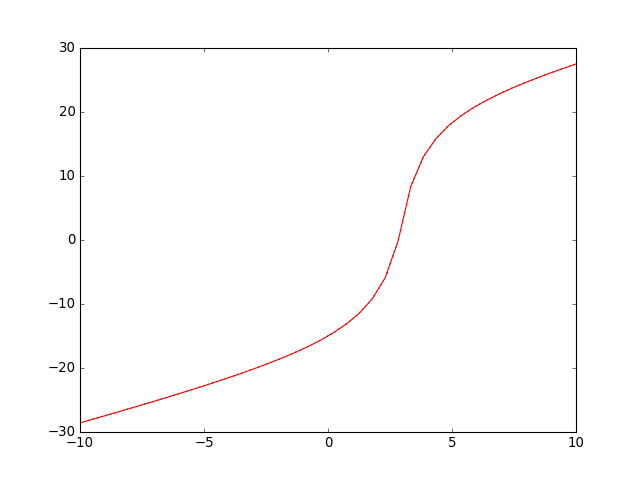

In [12]:
fig, ax = plt.subplots()
plot_fit(ax, flat.eval())

## fit

In [13]:
loss = tm.loss_deterministic(model)
optimizer_kwargs = tm.numericalize(loss, flat, batch_mapreduce=meanmap)

In [14]:
fit = minimize(
    args=(ys,xs),
#     method="CG",
    method="Newton-CG",
    options={'maxiter':100, 'disp':True},
    callback=lambda xs: plot_fit(ax, xs),
    **tm.scipy_kwargs(optimizer_kwargs)
); fit

batch_precompile
batch_precompile
batch_precompile
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 57
         Function evaluations: 64
         Gradient evaluations: 120
         Hessian evaluations: 57


     fun: 3.615532812556356e-07
     jac: array([ -3.07991179e-03,   1.18630197e-03,   2.01447638e-05])
 message: 'Optimization terminated successfully.'
    nfev: 64
    nhev: 57
     nit: 57
    njev: 120
  status: 0
 success: True
       x: array([-2.00017711,  3.16855287,  3.00000292])

Fix fitted parameters into model.

We need to further build a givens dictionary supply the input-info which usually is given when used as theano.function(model['inputs'], model['outputs']).

In [15]:
parameters_human_readable = model['parameters_positive'] + model['parameters']
parameters_target = [p.eval() for p in target['parameters_positive'] + target['parameters']]
to_human_readable = theano.function([flat], parameters_human_readable)
for p, num, tnum in zip(parameters_human_readable, to_human_readable(fit.x), parameters_target):
    print "%40s : %10g ~ %g" % (p.name, num, tnum)

          RadialTransform2.alpha_reparam :    1.00035 ~ 1
     RadialTransform2.beta+alpha_reparam :    21.0017 ~ 21
            RadialTransform2.z0_centered :          3 ~ 3


# two dimensions

## target

In [16]:
target2d = dm.RadialTransform(init_alpha=1, init_beta=5, init_z0=[3, 1])
# target2d = dm.RadialTransform(init_alpha=50, init_beta=-40, init_z0=[3, 1])

In [17]:
f_target2d = target2d.function()
example_target2d = [7, 4]
f_target2d(example_target2d)  # caution, needs vector not scalar input

array([ 10.33333333,   6.5       ])

In [18]:
N2d = 10
_xs = np.linspace(-10, 10, N2d)
X1, X2 = np.meshgrid(_xs, _xs)
xs2d = np.c_[X1.flat, X2.flat]
xs2d[:5]

array([[-10.        , -10.        ],
       [ -7.77777778, -10.        ],
       [ -5.55555556, -10.        ],
       [ -3.33333333, -10.        ],
       [ -1.11111111, -10.        ]])

In [19]:
ys2d = np.array([f_target2d(x) for x in xs2d])
ys2d[:5]

array([[-13.60522531, -13.05057526],
       [-11.06368242, -13.35365526],
       [ -8.41972766, -13.68250699],
       [ -5.64595806, -14.01666399],
       [ -2.72417999, -14.31604917]])

## model

In [20]:
model2d = dm.RadialTransform(input=xs2d[0])
model2d

RadialTransform4 { 'inputs': [TensorConstant{(2,) of -10.0}],
  'norm_det': RadialTransform4.norm_det,
  'outputs': RadialTransform4.outputs,
  'parameters': [RadialTransform4.z0],
  'parameters_positive': [RadialTransform4.alpha, RadialTransform4.beta+alpha]}

In [21]:
parameters2d = tm.prox_reparameterize(model2d['parameters_positive'], tm.squareplus, tm.squareplus_inv)
parameters2d += model2d['parameters']
flat2d = tm.prox_flatten(tm.prox_center(parameters2d))

## visualization

In [22]:
diff2d = ys2d - xs2d
quiver_kwargs = dict(scale=1, angles='xy', scale_units='xy', width=0.003)

f_model2d = theano.function([flat2d]+model2d['inputs'], model2d['outputs'])
    
def plot_fit2d(ax, wrt, time_delay=0.1, expand_factor=0.4):
    ax.clear()
    # target data:
    ax.quiver(xs2d[:,0], xs2d[:,1], diff2d[:,0], diff2d[:,1], hatch='***', facecolor='none', color="k", **quiver_kwargs)
    
    # model:
    m_ys2d = np.array([f_model2d(wrt, x) for x in xs2d])
    m_diff2d = m_ys2d - xs2d
    ax.quiver(xs2d[:,0], xs2d[:,1], m_diff2d[:,0], m_diff2d[:,1], color="r", **quiver_kwargs)

    # ax.autoscale()  # does not work with arrows, do it manually:
    l, r, b, t = ax.axis()
    dx, dy = r - l, t - b
    ax.axis([l - expand_factor * dx, r + expand_factor * dx, b - expand_factor * dy, t + expand_factor * dy])
    
    ax.figure.canvas.draw()
    time.sleep(time_delay)

<IPython.core.display.Javascript object>


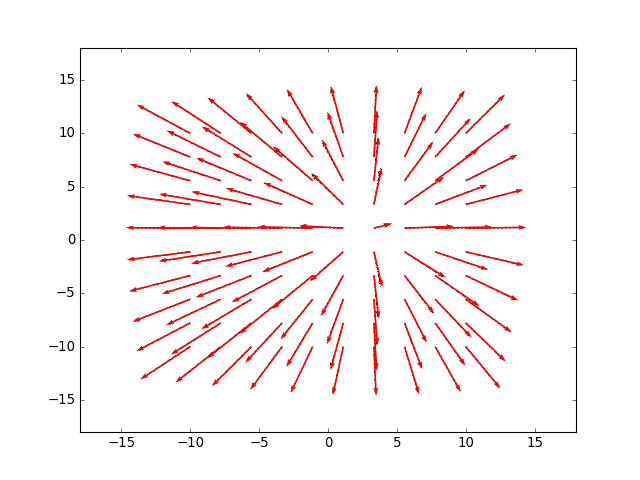

In [23]:
fig, ax = plt.subplots()
plot_fit2d(ax, flat2d.eval())

## fit

In [24]:
loss2d = tm.loss_deterministic(model2d)
optimizer_kwargs2d = tm.numericalize(loss2d, flat2d, batch_mapreduce=meanmap)

In [25]:
fit = minimize(
    args=(ys2d,xs2d),
#     method="CG",
    method="Newton-CG",
    options={'maxiter':100, 'disp':True},
    callback=lambda wrt: plot_fit2d(ax, wrt),
    **tm.scipy_kwargs(optimizer_kwargs2d)
); fit

batch_precompile
batch_precompile
batch_precompile
         Current function value: 0.000588
         Iterations: 100
         Function evaluations: 112
         Gradient evaluations: 211
         Hessian evaluations: 100


     fun: 0.0005881601901934006
     jac: array([ 0.01362373, -0.0154783 , -0.01661941, -0.00486323])
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 112
    nhev: 100
     nit: 100
    njev: 211
  status: 1
 success: False
       x: array([ 0.02637016,  1.05242927,  2.93998025,  0.98200159])

# Probabilistic Normalizing Flow

Only the combination with gaussian base function is shown. The uniform base function has the disadvantage of not being differentiable (not yet supported).

## model

In [26]:
base_model = pm.DiagGauss(output_size=2)
# CAUTION, this transform cannot be reused elsewhere, as it is merged into normalizing flow
# its references point always to the current substitution
transform_model = dm.RadialTransform()

In [27]:
model = tm.normalizing_flow(transform_model, base_model)
model

normalized_flow { 'inputs': [],
  'norm_det': RadialTransform5.norm_det,
  'outputs': RadialTransform5.outputs,
  'parameters': [RadialTransform5.z0, DiagGauss.mean],
  'parameters_positive': [ RadialTransform5.alpha,
                           RadialTransform5.beta+alpha,
                           DiagGauss.var]}

In [28]:
parameters = tm.prox_reparameterize(model['parameters_positive'], tm.softplus, tm.softplus_inv)
parameters += model['parameters']
flat = tm.prox_flatten(tm.prox_center(parameters))

## target

In [29]:
base_target = pm.DiagGauss(init_mean=[5,5], init_var=(10,5))
transform_target = dm.RadialTransform(init_z0=[5,5], init_beta=30, init_alpha=3)

In [30]:
target = tm.normalizing_flow(transform_target, base_target)
t_sampler = target.function()
t_sampler()

array([  4.57353381,  15.2817428 ])

In [31]:
n_samples = 2000
targets = np.array([t_sampler() for _ in xrange(n_samples)])

## visualization

In [32]:
scatter_kwargs = dict(edgecolors="face", alpha=0.01, s=5000)
outer = dict(i=0)
m_sampler = theano.function([flat], model['outputs'])
def plot_fit(ax, wrt, time_delay=0.1):
    outer['i'] += 1
    ax.clear()
    # targets
    ax.plot(targets[:,0], targets[:,1], 'k.')
#     ax.scatter(targets[:,0], targets[:,1], c='k', **scatter_kwargs)

    # model
    m_samples = np.array([m_sampler(wrt) for _ in xrange(n_samples)])
    ax.scatter(m_samples[:,0], m_samples[:,1], c='r',**scatter_kwargs)

    ax.figure.canvas.draw()
    if time_delay is not None:
        time.sleep(time_delay)

<IPython.core.display.Javascript object>


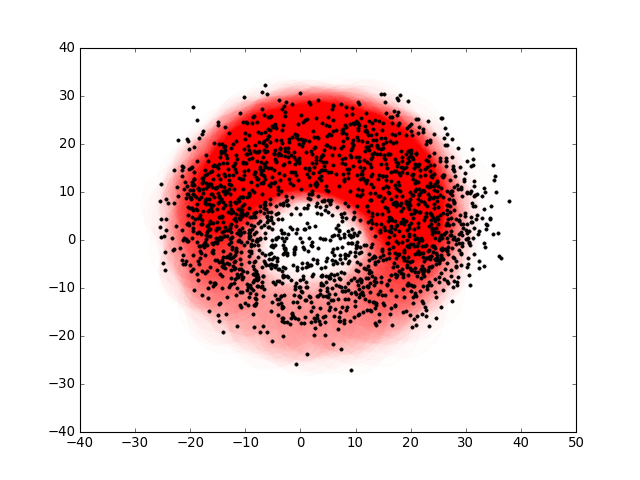

In [33]:
fig, ax = plt.subplots()
plot_fit(ax, flat.eval())

## fit

In [34]:
loss = tm.loss_probabilistic(model)
optimizer_kwargs = tm.numericalize(loss, flat, batch_mapreduce=meanmap)

In [35]:
fit = minimize(
    args=(targets,),
#     method='CG',
#     method="Newton-CG",
#     method="Nelder-Mead",
    options={'maxiter':1000, 'disp':True},
    callback=lambda wrt: plot_fit(ax, wrt, time_delay=None),
    **tm.scipy_kwargs(optimizer_kwargs)
); fit

batch_precompile
batch_precompile
         Current function value: 6.999906
         Iterations: 2
         Function evaluations: 21
         Gradient evaluations: 10


      fun: 6.9999063983475605
 hess_inv: array([[  1.00000108e+00,  -5.99521441e-06,   8.36438108e-06,
          3.06818562e-05,  -1.61490623e-06,  -1.49668374e-04,
          2.54123799e-05,   1.82861988e-04],
       [ -5.99521441e-06,   9.83673575e-01,   7.80588703e-04,
         -3.05158808e-03,  -8.14640712e-02,  -3.79939977e-02,
          8.29013517e-02,   3.99899590e-02],
       [  8.36438108e-06,   7.80588703e-04,   1.00198413e+00,
          4.79300451e-03,   6.63931933e-03,  -1.61634476e-02,
         -3.62119129e-03,   2.03457377e-02],
       [  3.06818562e-05,  -3.05158808e-03,   4.79300451e-03,
          1.01027903e+00,  -8.69971181e-03,  -4.92378084e-02,
          1.62020317e-02,   5.96379145e-02],
       [ -1.61490623e-06,  -8.14640712e-02,   6.63931933e-03,
         -8.69971181e-03,   5.97529278e-01,  -2.15040115e-01,
          4.14013067e-01,   2.31059816e-01],
       [ -1.49668374e-04,  -3.79939977e-02,  -1.61634476e-02,
         -4.92378084e-02,  -2.15040115e-01,   1.0753

Using the default scipy optimizer, one can see very good, that the problem is ill-defined in that the maximum likelihood solution is a ill-formed solution.

# adding regularizer

In [36]:
loss_reg = tm.loss_regularizer(loss, flat, regularizer_scalar=0.1)
optimizer_kwargs = tm.numericalize(loss_reg, flat, batch_mapreduce=meanmap)

In [38]:
fit = minimize(
    args=(targets,),
#     method='CG',
#     method="Newton-CG",
#     method="Nelder-Mead",
    options={'maxiter':1000, 'disp':True},
    callback=lambda wrt: plot_fit(ax, wrt, time_delay=0.001),
    **tm.scipy_kwargs(optimizer_kwargs)
); fit

         Current function value: 12.077579
         Iterations: 10
         Function evaluations: 31
         Gradient evaluations: 19


      fun: 12.077578743596945
 hess_inv: array([[ 1.21940509, -1.24506655,  0.22427995, -0.11680267, -0.13238167,
        -0.20476238, -0.22846314, -0.04251776],
       [-1.24506655,  7.95231484, -3.829598  , -0.48411499,  0.317232  ,
         1.19556556,  1.73693662,  0.17113395],
       [ 0.22427995, -3.829598  ,  8.83951942,  3.28963972,  0.27281912,
        -0.4858094 , -1.39238516, -0.14578382],
       [-0.11680267, -0.48411499,  3.28963972,  2.56605261,  0.22704041,
        -0.07822507, -0.37091045,  0.04182044],
       [-0.13238167,  0.317232  ,  0.27281912,  0.22704041,  0.86904395,
         0.06109107,  0.23328746,  0.01619391],
       [-0.20476238,  1.19556556, -0.4858094 , -0.07822507,  0.06109107,
         0.82160121,  0.28894053,  0.41822685],
       [-0.22846314,  1.73693662, -1.39238516, -0.37091045,  0.23328746,
         0.28894053,  1.26971179,  0.03626566],
       [-0.04251776,  0.17113395, -0.14578382,  0.04182044,  0.01619391,
         0.41822685,  0.03626566,  0.61

In [45]:
parameters_human = model['parameters'] + model['parameters_positive']
target_parameters_human = [p.eval() for p in target['parameters'] + target['parameters_positive']]
num_parameters_human = theano.function([flat], parameters_human)
for p, n, t in zip(parameters_human, num_parameters_human(fit.x), target_parameters_human):
    print "%40s : %30s ~ %s" % (p.name, n, t)

            RadialTransform5.z0_centered :      [ 1.6731743  -0.16960791] ~ [ 5.  5.]
                 DiagGauss.mean_centered :      [ 2.48579469  3.15996319] ~ [ 5.  5.]
          RadialTransform5.alpha_reparam :                0.0562023915308 ~ 3.0
     RadialTransform5.beta+alpha_reparam :                  15.3085504961 ~ 33.0
                   DiagGauss.var_reparam :      [ 9.07013758  7.67951542] ~ [ 10.   5.]


----

section 5 and 6 are not really needed. They do not work either.

----

# probabilistic chaining (without prior) NOTE: the log-lik is theoreticall in appropriate, because averaging should happen in logscale, however this is numerically extremely unstable, especially in the jacobian... unfortunately

## model

In [46]:
data_model = pm.Gauss(2, init_var=np.exp(-2))
data_model = tm.Merge(data_model, parameters_positive=None) # fix outer variance (mean gets proxified)
data_model

Merge4 { 'inputs': [], 'outputs': Gauss.outputs, 'parameters': [Gauss.mean]}

In [47]:
param_model_base = pm.DiagGauss(2)
param_model_normflows = [dm.RadialTransform(init_beta=10, )]

param_model = param_model_base
for transform in param_model_normflows:
    param_model = tm.normalizing_flow(transform, param_model)  # returns Merge
param_model

normalized_flow3 { 'inputs': [],
  'norm_det': RadialTransform7.norm_det,
  'outputs': RadialTransform7.outputs,
  'parameters': [RadialTransform7.z0, DiagGauss3.mean],
  'parameters_positive': [ RadialTransform7.alpha,
                           RadialTransform7.beta+alpha,
                           DiagGauss3.var]}

In [48]:
data_model['parameters'] = param_model
model = tm.Merge(data_model, param_model)
model

Merge6 { 'inputs': [],
  'norm_det': RadialTransform7.norm_det,
  'outputs': Gauss.outputs,
  'parameters': [RadialTransform7.z0, DiagGauss3.mean],
  'parameters_positive': [ RadialTransform7.alpha,
                           RadialTransform7.beta+alpha,
                           DiagGauss3.var]}

In [49]:
parameters = tm.prox_reparameterize(model['parameters_positive'], tm.softplus, tm.softplus_inv)
# parameters = tm.prox_reparameterize(model['parameters_positive'], tm.squareplus, tm.squareplus_inv)
parameters += model['parameters']
flat = tm.prox_flatten(tm.prox_center(parameters))

## target

In [50]:
data_target = pm.Gauss(2, init_var=np.exp(-2))
data_target

Gauss2 { 'inputs': [],
  'outputs': Gauss2.outputs,
  'parameters': [Gauss2.mean],
  'parameters_positive': [Gauss2.var]}

In [51]:
param_target_base = pm.DiagGauss(init_mean=[5,5], init_var=(10,5))
param_target_normflows = [dm.RadialTransform(init_z0=[5,5], init_beta=80, init_alpha=3)]

In [52]:
param_target = param_target_base
for transform in param_target_normflows:
    param_target = tm.normalizing_flow(transform, param_target)  # returns Merge
param_target

normalized_flow4 { 'inputs': [],
  'norm_det': RadialTransform8.norm_det,
  'outputs': RadialTransform8.outputs,
  'parameters': [RadialTransform8.z0, DiagGauss4.mean],
  'parameters_positive': [ RadialTransform8.alpha,
                           RadialTransform8.beta+alpha,
                           DiagGauss4.var]}

In [53]:
data_target['parameters'] = param_target
target = tm.Merge(data_target, param_target)  # logP not needed, hence no variational_lower_bound
target

Merge9 { 'inputs': [],
  'norm_det': RadialTransform8.norm_det,
  'outputs': Gauss2.outputs,
  'parameters': [RadialTransform8.z0, DiagGauss4.mean],
  'parameters_positive': [ Gauss2.var,
                           RadialTransform8.alpha,
                           RadialTransform8.beta+alpha,
                           DiagGauss4.var]}

In [54]:
t_sampler = target.function()
n_samples = 2000
targets = np.array([t_sampler() for _ in xrange(n_samples)])

## Visualization

In [76]:
scatter_kwargs = dict(edgecolors="face", alpha=0.01, s=5000)
outer = dict(i=0)
m_sampler = theano.function([flat], model['outputs'])

def plot_fit(ax, wrt, time_delay=0.1):
    outer['i'] += 1
    ax.clear()
    # targets
    ax.plot(targets[:,0], targets[:,1], 'k.')
#     ax.scatter(targets[:,0], targets[:,1], c='k', **scatter_kwargs)

    # model
    m_samples = np.array([m_sampler(wrt) for _ in xrange(n_samples)])
    ax.scatter(m_samples[:,0], m_samples[:,1], c='r',**scatter_kwargs)

    ax.figure.canvas.draw()
    if time_delay is not None:
        time.sleep(time_delay)

In [84]:
tm.check_all_identities()
batch_size = 20
n_batches = len(targets) // batch_size
climin_args = izip( imap(lambda x:(x,),  chunk(20, cycle(targets)) ) , repeat({}))

loss = tm.loss_regularizer(tm.loss_probabilistic(model), flat, regularizer_scalar=100)
optimizer_kwargs = tm.numericalize(loss, flat,
    batch_mapreduce=meanmap,
    adapt_init_params=lambda ps: ps + np.random.normal(size=ps.shape, scale=10),
    exp_average_n=10,
    exp_ratio_estimator=None
)

<IPython.core.display.Javascript object>


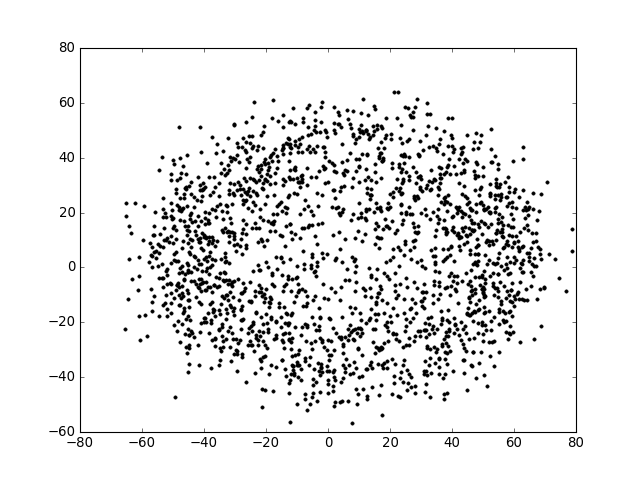

In [85]:
fig, ax = plt.subplots()
plot_fit(ax, flat.eval())

In [83]:
fit = minimize(
    args=(targets[:100],),
#     method='CG',
    method="Newton-CG",
#     method="Nelder-Mead",
    options={'maxiter':1000, 'disp':True},
    callback=lambda wrt: plot_fit(ax, wrt, time_delay=None),
    **tm.scipy_kwargs(optimizer_kwargs)
); fit

         Current function value: 17964.011499
         Iterations: 0
         Function evaluations: 19
         Gradient evaluations: 8
         Hessian evaluations: 0


     fun: 17964.011499185017
     jac: array([ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan])
 message: 'Desired error not necessarily achieved due to precision loss.'
    nfev: 19
    nhev: 0
     nit: 0
    njev: 8
  status: 2
 success: False
       x: array([  4.88541677, -16.49895339,  14.24659948,   0.80579803,
         2.26452924, -10.11105359,  -8.23215395,   2.57723265])

In [79]:
opt = optimizer(
#     identifier='adadelta',
    identifier="adam",
#     identifier="rmsprop",
    step_rate=1e-1,
#     step_rate=1.2,
#     momentum=0.9,
    args=climin_args,
    **tm.climin_kwargs(optimizer_kwargs)
)

In [86]:
human_readable_parameters = model['parameters'] + model['parameters_positive']
f = theano.function([flat], human_readable_parameters)
old_num_params = f(opt.wrt)
        
with ignored(KeyboardInterrupt):
    for info in opt:  #every(n_batches, opt):
        num_params = f(opt.wrt)
        print "jacobiannames", str(flat)
        print "jacobian", optimizer_kwargs['num_jacobian'](opt.wrt, targets[:batch_size])
        diff_params = [n - o for n, o in izip(num_params, old_num_params)]
        print("params")
        pprint(dict(zip(map(str, human_readable_parameters), num_params)))
        print("diff")
        pprint(dict(zip(map(str, human_readable_parameters), diff_params)))
        print
        plot_fit(ax, opt.wrt, time_delay=None)

jacobiannames "RadialTransform7.alpha_softplus_centered:RadialTransform7.beta+alpha_softplus_centered:DiagGauss3.var_softplus_centered:RadialTransform7.z0_centered:DiagGauss3.mean_centered"
jacobian [ nan  nan  nan  nan  nan  nan  nan  nan]
params
{'DiagGauss3.mean_centered': array([ nan,  nan]),
 'DiagGauss3.var_reparam': array([ nan,  nan]),
 'RadialTransform7.alpha_reparam': array(nan),
 'RadialTransform7.beta+alpha_reparam': array(nan),
 'RadialTransform7.z0_centered': array([ nan,  nan])}
diff
{'DiagGauss3.mean_centered': array([ nan,  nan]),
 'DiagGauss3.var_reparam': array([ nan,  nan]),
 'RadialTransform7.alpha_reparam': nan,
 'RadialTransform7.beta+alpha_reparam': nan,
 'RadialTransform7.z0_centered': array([ nan,  nan])}

jacobiannames "RadialTransform7.alpha_softplus_centered:RadialTransform7.beta+alpha_softplus_centered:DiagGauss3.var_softplus_centered:RadialTransform7.z0_centered:DiagGauss3.mean_centered"
jacobian [ nan  nan  nan  nan  nan  nan  nan  nan]
params
{'DiagGaus

## testings

In [87]:
optimizer_kwargs['num_loss'](optimizer_kwargs['num_parameters'], targets[:10])

21672.209110267297

In [88]:
print "loss", optimizer_kwargs['num_loss'](optimizer_kwargs['num_parameters'], targets[:10])
print "jacobian", optimizer_kwargs['num_jacobian'](optimizer_kwargs['num_parameters'], targets[:10])

loss 21092.5697444
jacobian [ nan  nan  nan  nan  nan  nan  nan  nan]


In [89]:
print "loss", optimizer_kwargs['num_loss'](optimizer_kwargs['num_parameters'], targets[:10])
print "jacobian", optimizer_kwargs['num_jacobian'](optimizer_kwargs['num_parameters'], targets[:10])

loss 20976.49669
jacobian [ nan  nan  nan  nan  nan  nan  nan  nan]


In [97]:
optimizer_kwargs['num_jacobian'].wrapped

<function theano_models.loss._f>

In [93]:
tm.d3viz(optimizer_kwargs['num_jacobian'].wrapped.wrapped, "tmp/num_jacobian.html", match_by_names=True)
IFrame("tmp/num_jacobian.html", width=700, height=500)

AttributeError: 'function' object has no attribute 'wrapped'

In [ ]:
tm.d3viz(optimizer_kwargs['num_loss'].wrapped.wrapped, "tmp/num_loss.html", match_by_names=True)
IFrame("tmp/num_loss.html", width=700, height=500)

In [101]:
tm.d3viz(loss, "tmp/loss.html")
IFrame("tmp/loss.html", width=700, height=500)

# variational inference (with prior)

## Model

In [109]:
data_model = pm.Gauss(2, init_var=np.exp(-2))
data_model = tm.Merge(data_model, parameters_positive=None) # fix outer variance
data_model

Merge16 { 'inputs': [], 'outputs': Gauss5.outputs, 'parameters': [Gauss5.mean]}

In [110]:
param_model_base = pm.DiagGauss(2)
param_model_normflows = [dm.RadialTransform()]

param_model = param_model_base
for transform in param_model_normflows:
    param_model = tm.normalizing_flow(transform, param_model)  # returns Merge
param_model

normalized_flow7 { 'inputs': [],
  'norm_det': RadialTransform11.norm_det,
  'outputs': RadialTransform11.outputs,
  'parameters': [RadialTransform11.z0, DiagGauss7.mean],
  'parameters_positive': [ RadialTransform11.alpha,
                           RadialTransform11.beta+alpha,
                           DiagGauss7.var]}

In [111]:
prior = tm.fix_params(pm.Gauss(2, init_var=np.exp(1)))
prior

Gauss6_fixed { 'inputs': [], 'outputs': Gauss6.outputs}

In [112]:
model = tm.variational_bayes(data_model, 'parameters', param_model, priors=prior)

# UncertainWeights uses softplus parameterization
parameters = tm.prox_reparameterize(model['parameters_positive'], tm.softplus, tm.softplus_inv)
parameters += model['parameters']
flat = tm.prox_flatten(tm.prox_center(parameters))

## Fit Visualization

In [113]:
scatter_kwargs = dict(edgecolors="face", alpha=0.01, s=5000)
outer = dict(i=0)
m_sampler = theano.function([flat], model['outputs'])
def plot_fit(ax, wrt, time_delay=0.1):
    outer['i'] += 1
    ax.clear()
    # targets
    ax.plot(targets[:,0], targets[:,1], 'k.')
#     ax.scatter(targets[:,0], targets[:,1], c='k', **scatter_kwargs)
    # model
    m_samples = np.array([m_sampler(wrt) for _ in xrange(n_samples)])
    ax.scatter(m_samples[:,0], m_samples[:,1], c='r',**scatter_kwargs)

    fig.canvas.draw()
    if time_delay is not None:
        time.sleep(time_delay)

<IPython.core.display.Javascript object>


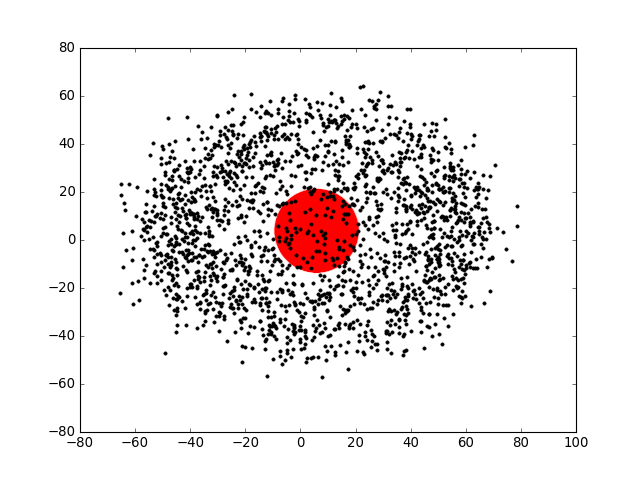

In [114]:
fig, ax = plt.subplots()
plot_fit(ax, flat.eval())

In [115]:
tm.check_all_identities()
model['n_data'].set_value(n_samples)
# model['n_data'].set_value(1)

In [117]:
batch_size = 20
n_batches = len(targets) // batch_size
climin_args = izip( imap(lambda x:(x,),  chunk(20, cycle(targets)) ) , repeat({}))

def weights_data():
    for t in xrange(10000):
        yield min(1, 0.01 + t/10000)
    while True:
        yield 1
        
def weights_regularizer_1epoch():
    for i in range(1, n_batches+1):
        yield 2**(n_batches - i) / (2**n_batches - 1)
        
loss = tm.loss_variational(model)
optimizer_kwargs = tm.numericalize(loss, flat,
    batch_mapreduce=summap,
#     wrapper=as_wrapper(Average(30)),
    annealing_combiner=tm.AnnealingCombiner(
#         weights_data=weights_data()
        weights_regularizer=cycle(weights_regularizer_1epoch())
    ),
    adapt_init_params=lambda ps: ps + np.random.normal(size=ps.shape, scale=10)
)

In [118]:
opt = optimizer(
#     identifier='adadelta',
#     identifier="adam",
    identifier="rmsprop",
    step_rate=1e-1,
#     step_rate=1.2,
    momentum=0.9,
    args=climin_args,
    **tm.climin_kwargs(optimizer_kwargs)
)

batch_precompile
batch_precompile


In [119]:
human_readable_parameters = model['parameters'] + model['parameters_positive']
f = theano.function([flat], human_readable_parameters)
old_num_params = f(opt.wrt)
        
with ignored(KeyboardInterrupt):
    for info in opt:  #every(n_batches, opt):
        num_params = f(opt.wrt)
        print "jacobian", optimizer_kwargs['num_jacobian'](opt.wrt, targets[:batch_size])
        diff_params = [n - o for n, o in izip(num_params, old_num_params)]
        print("params")
        pprint(dict(zip(map(str, human_readable_parameters), num_params)))
        print("diff")
        pprint(dict(zip(map(str, human_readable_parameters), diff_params)))
        print
        plot_fit(ax, opt.wrt, time_delay=None)

jacobian [ -85.30005692   75.89088947  -13.80533632  -10.33138693   10.51390571
  -10.23799107  -31.49419044  135.27795389]
params
{'DiagGauss7.mean_centered': array([ -1.68660092,  16.37444015]),
 'DiagGauss7.var_reparam': array([ 1.44037407,  5.6558293 ]),
 'RadialTransform11.alpha_reparam': array(3.348703145553138),
 'RadialTransform11.beta+alpha_reparam': array(6.712608522923164),
 'RadialTransform11.z0_centered': array([-9.85547922,  1.35602462])}
diff
{'DiagGauss7.mean_centered': array([ 0.31622676, -0.31622764]),
 'DiagGauss7.var_reparam': array([-0.24984337, -0.31527608]),
 'RadialTransform11.alpha_reparam': 0.30324588545216891,
 'RadialTransform11.beta+alpha_reparam': -0.3158979134455544,
 'RadialTransform11.z0_centered': array([-0.31621214,  0.31618461])}

jacobian [ -82.17803537   75.12394137   -2.14074626    9.59911427    8.4576909
   -7.69203916  -39.80752475  136.51515624]
params
{'DiagGauss7.mean_centered': array([ -1.1134685 ,  15.87543569]),
 'DiagGauss7.var_reparam': 

In [120]:
scipy_kwargs = tm.scipy_kwargs(optimizer_kwargs)

fit = minimize(
    args=(targets,),
#     method='CG',
#     method="Newton-CG",
    method="Nelder-Mead",
    options={'maxiter':1000, 'disp':True},
    callback=lambda wrt: plot_fit(ax,wrt, time_delay=None),
    **scipy_kwargs
); fit

KeyboardInterrupt: 

# test norm_Det

In [121]:
tr = dm.RadialTransform(init_alpha=4, init_beta=5, init_z0=[5,2])

In [122]:
f = theano.function(tr['inputs'], tr['norm_det'])

In [123]:
f([1,2])

array(2.1328125)

In [124]:
from theano import gradient
from theano.tensor import nlinalg
jac = gradient.jacobian(tr['outputs'], tr['inputs'][0])
norm_det = nlinalg.Det()(jac)
f2 = theano.function(tr['inputs'], norm_det)

In [125]:
f2([1,2])

array(2.1328125)